# Technology focus: 10x Genomics Visium
This notebook will present a rough overview of the plotting functionalities that `spatialdata` implements for Visium data.

## Loading the data
Please download the data from here: [Visium dataset](https://s3.embl.de/spatialdata/spatialdata-sandbox/visium.zip) and rename it (eventually using symlinks) to `visium_brain.zarr`.


In [1]:
visium_zarr_path = "./visium_brain.zarr"

In [2]:
import spatialdata as sd

visium_sdata = sd.read_zarr(visium_zarr_path)
visium_sdata

C:\Users\w-mv\.conda\envs\sdata_develop\lib\site-packages\anndata\_core\anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
C:\Users\w-mv\AppData\Local\Temp\ipykernel_25216\2978711104.py:3: DeprecationWarning: Table group found in zarr store at location C:\Users\w-mv\PycharmProjects\spatialdata-notebooks\notebooks\examples\visium_brain.zarr. Please update the zarr storeto use tables instead.
  visium_sdata = sd.read_zarr(visium_zarr_path)
C:\Users\w-mv\.conda\envs\sdata_develop\lib\site-packages\anndata\_core\anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


SpatialData object with:
├── Images
│     ├── 'ST8059048_hires_image': SpatialImage[cyx] (3, 2000, 1969)
│     ├── 'ST8059048_lowres_image': SpatialImage[cyx] (3, 600, 591)
│     ├── 'ST8059050_hires_image': SpatialImage[cyx] (3, 2000, 1968)
│     ├── 'ST8059050_image': SpatialImage[cyx] (3, 2000, 1968)
│     ├── 'ST8059050_lowres_image': SpatialImage[cyx] (3, 600, 590)
│     └── 'ST8059052_image': SpatialImage[cyx] (3, 2000, 1950)
├── Shapes
│     ├── 'ST8059048': GeoDataFrame shape: (2987, 2) (2D shapes)
│     ├── 'ST8059050': GeoDataFrame shape: (3497, 2) (2D shapes)
│     ├── 'ST8059050_shapes': GeoDataFrame shape: (3497, 2) (2D shapes)
│     └── 'ST8059052_shapes': GeoDataFrame shape: (2576, 2) (2D shapes)
└── Tables
      └── 'table': AnnData (6484, 31053)
with coordinate systems:
▸ 'ST8059048', with elements:
        ST8059048_hires_image (Images), ST8059048 (Shapes)
▸ 'ST8059050', with elements:
        ST8059050_hires_image (Images), ST8059050_image (Images), ST8059050 (Shapes

## Visualise the data
We're going to create a naiive visualisation of the data, overlaying the Visium spots and the tissue images. For this, we need to load the `spatialdata_plot` library which extends the `sd.SpatialData` object with the `.pl` module. 

C:\Users\w-mv\Documents\Phd_project\sdata\src\spatialdata\_core\spatialdata.py:157: UserWarning: The table is annotating 'ST8059048', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
C:\Users\w-mv\Documents\Phd_project\sdata\src\spatialdata\_core\spatialdata.py:157: UserWarning: The table is annotating 'ST8059048', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


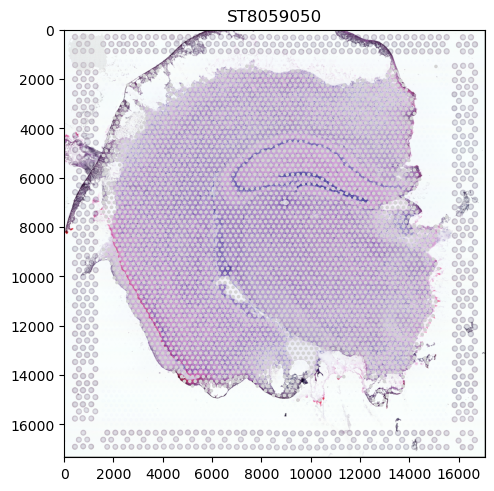

In [3]:
import spatialdata_plot

visium_sdata.pl.render_images().pl.render_shapes().pl.show("ST8059050")

We can see that the data contains two coordinate systems (`ST8059050` and `ST8059052`) with image and spot information each. In `SpatialData`, these spots are represented as `Shapes`. When giving no further parameters, one panel is generated per coordinate system with the members that have been specified in the function call. We can see that the spots are aligned to the tissue representation which is also respected by the plotting logic.

However, the spots are all grey since we have not provided any information on what they should encode. Such information can be found in the `Table` attribute (which is an `anndata.AnnData` table) of the `SpatialData` object, either in the data itself or the `obs` attribute.

In [4]:
visium_sdata["table"].to_df().sum(axis=0).sort_values(ascending=False).head(10)
# We will select some of the highly expressed genes for this example

mt-Co3     3292649.0
mt-Co1     3061428.0
mt-Atp6    2124067.0
mt-Co2     2110283.0
mt-Cytb    1288126.0
mt-Nd4     1073436.0
mt-Nd1     1073275.0
Ttr         832128.0
Fth1        828627.0
mt-Nd2      755237.0
dtype: float32

In [5]:
visium_sdata["table"].obs.head(3)

,in_tissue,array_row,array_col,spot_id,region
AAACAAGTATCTCCCA-1,1,50,102,0,ST8059048
AAACACCAATAACTGC-1,1,59,19,1,ST8059048
AAACAGAGCGACTCCT-1,1,14,94,2,ST8059048


### Color the visium spots by gene expression
To use this information in our plot, we pass the name of the column by which we want to color our expression to `color`. Furthermore, we are going to subset the data to only one coordinate system.

C:\Users\w-mv\Documents\Phd_project\sdata\src\spatialdata\_core\spatialdata.py:157: UserWarning: The table is annotating 'ST8059048', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
C:\Users\w-mv\.conda\envs\sdata_develop\lib\site-packages\anndata\_core\anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
C:\Users\w-mv\Documents\Phd_project\sdata\src\spatialdata\_core\_elements.py:112: UserWarning: Key `table` already exists. Overwriting it.
  self._check_key(key, self.keys(), self._shared_keys)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
C:\Users\w-mv\Documents\Phd_project\sdata\src\spatialdata\_utils.py:210: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical = pd.api.types.is_ca

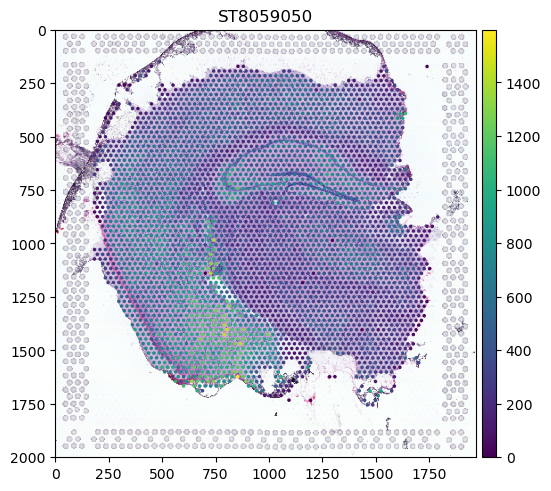

In [9]:
(
    visium_sdata.pp.get_elements("ST8059050")
    .pl.render_images(elements="ST8059050_hires_image")
    .pl.render_shapes(elements="ST8059050", color="mt-Co3")
    .pl.show()
)

We can also provide `ax` objects to `spatialdata_plot` for further customisation.

C:\Users\w-mv\Documents\Phd_project\sdata\src\spatialdata\_core\spatialdata.py:157: UserWarning: The table is annotating 'ST8059048', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
C:\Users\w-mv\.conda\envs\sdata_develop\lib\site-packages\anndata\_core\anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
C:\Users\w-mv\Documents\Phd_project\sdata\src\spatialdata\_core\_elements.py:112: UserWarning: Key `table` already exists. Overwriting it.
  self._check_key(key, self.keys(), self._shared_keys)
C:\Users\w-mv\Documents\Phd_project\sdata\src\spatialdata\_utils.py:210: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical = pd.api.types.is_categorical_dtype(obs[column])
C:\Users\w-mv\Documents\Phd_project\sdata\src\spatialdata\_utils.py:210: FutureWa

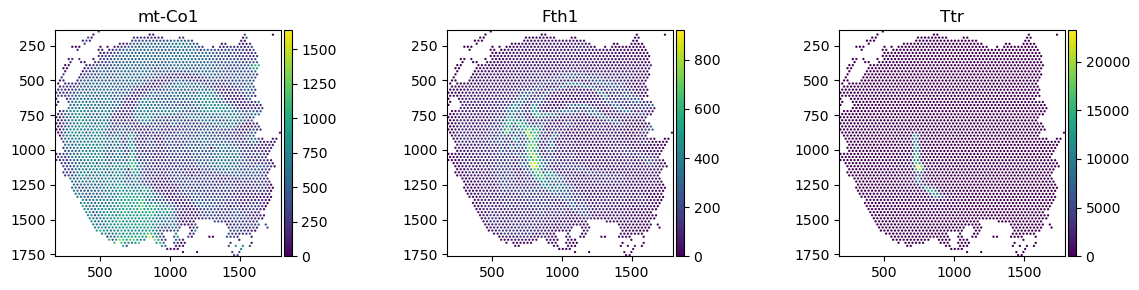

In [7]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(12, 3))

visium_sdata_subset = visium_sdata.pp.get_elements("ST8059050")

visium_sdata_subset.pl.render_shapes(elements="ST8059050", color="mt-Co1").pl.show(ax=axs[0], title="mt-Co1")

visium_sdata_subset.pl.render_shapes(elements="ST8059050", color="Fth1").pl.show(ax=axs[1], title="Fth1")

visium_sdata_subset.pl.render_shapes(elements="ST8059050", color="Ttr").pl.show(ax=axs[2], title="Ttr")

plt.tight_layout()